In [1]:
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC

from sklearn.feature_extraction import DictVectorizer

from sklearn import metrics
from sklearn.metrics import classification_report, precision_score, recall_score, make_scorer


from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV


import numpy as np

import json

import Feature_Extraction as fe

import pandas as pd
import numpy as np
import spacy
import nltk
from nltk.corpus import wordnet

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ga75xoh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
import wikipedia
import requests

In [55]:
x = wikipedia.search("data")

In [20]:
def getConceptNet5Similarity(term1, term2):
    return requests.get('http://api.conceptnet.io/relatedness?node1=/c/en/' + term1 + '&node2=/c/en/' + term2).json()['value']

In [58]:
term1 = 'car' #also check NASA and CIA examples
term2 = 'horn'
x = getConceptNet5Similarity(term1, term2)
y = fe.getWUPSimilarity(term1, term2)
if x == None:
    x = 0
if y == None:
    y = 0
z = (x+y) / 2
t = x
if y > x:
    t = y
#r1 = wikipedia.summary(term1, sentences=1)
#r2 = wikipedia.summary(term2, sentences=1)
u = fe.getNounSimilarityPortion(r1, r2)
print('ConceptNet5: ' + str(x))
print()
print('NLTK WUP: '+ str(y))
print()
#print('Wikipedia Summary: '+ str(u))
#print()
print('Average: ' + str(z))
print()
print('Smart: ' + str(t))


ConceptNet5: 0.163

NLTK WUP: 0.6

Average: 0.3815

Smart: 0.6


In [62]:
model='en_core_web_sm'
nlp = spacy.load(model)
from spacy.lang.en import English
parser = English()

In [63]:
def tokenize(text):
    lda_tokens = []
    tokens = parser(text)
    for token in tokens:
        if token.orth_.isspace():
            continue
        elif token.like_url:
            lda_tokens.append('URL')
        elif token.orth_.startswith('@'):
            lda_tokens.append('SCREEN_NAME')
        else:
            lda_tokens.append(token.lower_)
    return lda_tokens

In [64]:
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet as wn
def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma
    
from nltk.stem.wordnet import WordNetLemmatizer
def get_lemma2(word):
    return WordNetLemmatizer().lemmatize(word)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ga75xoh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [65]:
nltk.download('stopwords')
en_stop = set(nltk.corpus.stopwords.words('english'))
def prepare_text_for_lda(text):
    tokens = tokenize(text)
    tokens = [token for token in tokens if len(token) > 4]
    tokens = [token for token in tokens if token not in en_stop]
    tokens = [get_lemma(token) for token in tokens]
    return tokens

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ga75xoh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [68]:
text_data = []
with open('data/sentences.csv') as f:
    for line in f:
        tokens = prepare_text_for_lda(line)
        text_data.append(tokens)

In [74]:
from gensim import corpora
dictionary = corpora.Dictionary(text_data)
corpus = [dictionary.doc2bow(text) for text in text_data]
import pickle
pickle.dump(corpus, open('corpus.pkl', 'wb'))
dictionary.save('dictionary.gensim')

In [77]:
import gensim
NUM_TOPICS = 5
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
ldamodel.save('model5.gensim')
topics = ldamodel.print_topics(num_words=4)
for topic in topics:
    print(topic)

(0, '0.269*"irrigation" + 0.085*"aqualush" + 0.084*"setting" + 0.081*"allow"')
(1, '0.026*"current" + 0.026*"user" + 0.026*"aqualush" + 0.026*"allow"')
(2, '0.142*"aqualush" + 0.127*"current" + 0.096*"allow" + 0.096*"setting"')
(3, '0.303*"user" + 0.019*"current" + 0.019*"aqualush" + 0.019*"allow"')
(4, '0.150*"aqualush" + 0.122*"setting" + 0.096*"display" + 0.066*"problem"')


In [79]:
dictionary = gensim.corpora.Dictionary.load('dictionary.gensim')
corpus = pickle.load(open('corpus.pkl', 'rb'))
lda = gensim.models.ldamodel.LdaModel.load('model5.gensim')
import pyLDAvis.gensim
lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

C:\Users\ga75xoh\AppData\Local\Programs\Python\Python37\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt

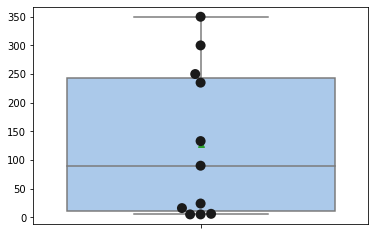

In [25]:
X = [235,24,5,6,300,350,90,16,250,133,5]
sns.swarmplot(x=X, size=10, color=".1", orient="v")
sns.boxplot(x=X, whis=np.inf, orient="v", showmeans=True, palette="pastel")

In [3]:
# load the dataset

data = open('data/tousend_cons_rels.CSV', encoding="ANSI").read()
label, r1, r2, rmix = [], [], [], []
size = 500
for i, line in enumerate(data.split("\n")):
    if i >= size:
        break
    if line != '' and line.isspace() != True:
        content = line.split(';')
        label.append(content[0])
        r1.append(content[1])
        r2.append(content[2])
        rmix.append(content[1]+content[2])
        
index = 0
size = len(label)
x = []
while index < size:
    x.append(fe.createFBag(r1[index], r2[index]))
    index = index + 1
    
vec = DictVectorizer()

xx = vec.fit_transform(x).toarray()

yy = []
for l in label:
    if l == 'true':
        yy.append(1)
    else:
        yy.append(-1)

In [76]:
def isStopWord(w):
    if w in set(nltk.corpus.stopwords.words('english')):
        return True
    return False

In [33]:
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
nltk.download('punkt')
nltk.download('stopwords')
def calculateCosine(s1, s2):
    sw = stopwords.words('english')  
    s1_list = word_tokenize(s1)  
    s2_list = word_tokenize(s2)
    # remove stop words from string 
    s1_set = {w for w in s1_list if not w in sw}  
    s2_set = {w for w in s2_list if not w in sw}
    l1 =[]
    l2 =[] 
    # form a set containing keywords of both strings  
    rvector = s1_set.union(s2_set)  
    for w in rvector: 
        if w in s1_set:
            l1.append(1)
        else:
            l1.append(0) 
        if w in s2_set:
            l2.append(1) 
        else:
            l2.append(0)
    c = 0
    # cosine formula
    for i in range(len(rvector)): 
        c+= l1[i]*l2[i]
    cosine = c / float((sum(l1)*sum(l2))**0.5)
    return cosine

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ga75xoh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ga75xoh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [41]:
def classifyCosine(s1, s2, threshold):
    cos = calculateCosine(s1, s2)
    if cos > threshold:
        return 1
    else:
        return -1

def classifyAllCosine(threshold):
    predicted = []
    for i in range(len(yy)):
        predicted.append(classifyCosine(r1[i], r2[i], threshold))
    return predicted

In [48]:
for i in np.arange(0,1,0.05):
    predicted = classifyAllCosine(i)
    print('--------------------')
    print(i)
    print(classification_report(yy, predicted))

--------------------
0.0
              precision    recall  f1-score   support

          -1       1.00      0.03      0.06       449
           1       0.10      1.00      0.19        51

    accuracy                           0.13       500
   macro avg       0.55      0.52      0.13       500
weighted avg       0.91      0.13      0.07       500

--------------------
0.05
              precision    recall  f1-score   support

          -1       1.00      0.03      0.06       449
           1       0.10      1.00      0.19        51

    accuracy                           0.13       500
   macro avg       0.55      0.52      0.13       500
weighted avg       0.91      0.13      0.07       500

--------------------
0.1
              precision    recall  f1-score   support

          -1       0.91      0.09      0.17       449
           1       0.10      0.92      0.19        51

    accuracy                           0.18       500
   macro avg       0.51      0.51      0.18       50

In [148]:
def classifyOnSimilarity(s1, s2):
    threshold = 0.3
    ns = fe.getNounSimilarityPortion(s1, s2)
    if ns == 'low':
        ns = 0
    vs = fe.getVerbSimilarityPortion(s1, s2)
    if vs == 'low':
        vs = 0
    sim = (ns + vs) / 2
    myy = -1
    if sim > threshold:
        myy = 1
    return myy